In [1]:
import geopandas as gpd
import laspy
from shapely.geometry import Polygon, Point
import numpy as np
import matplotlib.pyplot as plt
import copy
import shapely as shp
import open3d as o3d
import pickle
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Loading data

In [2]:
os.system('sudo blobfuse /home/azureuser/cloudfiles/code/blobfuse/sidewalk --tmp-path=/mnt/resource/blobfusetmp --config-file=/home/azureuser/cloudfiles/code/blobfuse/fuse_connection_sidewalk.cfg -o attr_timeout=3600 -o entry_timeout=3600 -o negative_timeout=3600 -o allow_other -o nonempty')


0

In [3]:
# Function to load point clouds
def load_pcs(folder):
    pc_list = []

    for filename in os.listdir(folder):
        file = os.path.join(folder, filename)
        pc = laspy.read(file)
        name = filename.split(".")[0]
        pc_list.append({"name": name, "laz_file": pc})

    return pc_list

In [4]:
# Load point clouds
PCs = load_pcs("/home/azureuser/cloudfiles/code/blobfuse/sidewalk/processed_data/crossings_project/CW cleaning/PCs")

# Add additional info to point cloud dictionaries  
for pc in PCs:
    pc['xyz'] = pc['laz_file'].xyz
    pc['intensity'] = pc['laz_file'].intensity

In [5]:
# Load polygons
CW_polygons = gpd.read_file("/home/azureuser/cloudfiles/code/blobfuse/sidewalk/processed_data/crossings_project/tiles/Osdorp complete/21 output/CW_polygons_21_RD.shp")

# Down sampling point clouds

In [6]:
def cut_PC(pc):
    # Find coordinates below threshold
    indices = np.where(pc['xyz'][:, 2] < 1)
    z = pc['xyz'][:, 2]
    average_z = np.mean(z)

    # Cut intensity accordingly
    pc['PC_intensity_low'] = pc['intensity'][indices]
    pc['PC_coords_low'] = pc['xyz'][indices]

    # Compute average and std z
    z = pc['PC_coords_low'][:, 2]
    average_z = np.mean(z)
    sd_z = np.std(z)
    threshold = average_z + sd_z

    # Compute points above threshold
    indices_thres = np.where(pc['PC_coords_low'][:, 2] < threshold)
    pc['PC_intensity_std'] =  pc['PC_intensity_low'][indices_thres] 
    pc['PC_coords_std'] =  pc['PC_coords_low'][indices_thres] 

    return pc

In [7]:
for pc in PCs:
    pc = cut_PC(pc)

In [8]:
def down_sample_PC(pc, coords, intensity_str):
    xyz = pc[coords]
    intensity = pc[intensity_str]
    
    # Convert to Open3D point cloud using only XYZ
    pc_o3d = o3d.geometry.PointCloud()
    pc_o3d.points = o3d.utility.Vector3dVector(xyz)

    # Perform voxel downsampling
    downsampled_pc_o3d = pc_o3d.voxel_down_sample(0.02)

    # Retrieve downsampled XYZ points
    pc[coords + "_ds"] = np.asarray(downsampled_pc_o3d.points) 

    # Create a KDTree for the original point cloud
    tree = cKDTree(xyz)

    # For each downsampled point, find its nearest neighbor in the original cloud
    _, indices = tree.query(pc[coords + '_ds'])

    # Get indices of intensity
    pc[intensity_str + "_ds"] = intensity[indices]

    return pc


In [9]:
for pc in PCs:
    pc = down_sample_PC(pc, "PC_coords_std", "PC_intensity_std")
    print(pc['name'])
    print("all points: ", len(pc['xyz']))
    print("points after downsampling: ", len(pc['PC_coords_std_ds']))
    print("total points removed: ", len(pc['xyz']) - len(pc['PC_coords_std_ds']))
    print("----------------------------------------")

filtered_2282_9724
all points:  1795878
points after downsampling:  407941
total points removed:  1387937
----------------------------------------
filtered_2282_9725
all points:  6141444
points after downsampling:  4197546
total points removed:  1943898
----------------------------------------
filtered_2283_9724
all points:  3468038
points after downsampling:  2196553
total points removed:  1271485
----------------------------------------
filtered_2283_9725
all points:  6947224
points after downsampling:  4300205
total points removed:  2647019
----------------------------------------


# Plotting function

In [10]:
# Function to plot CW
def plot_PC_2D(PC_pol_dict, coords, intensity):
    x = PC_pol_dict[coords][:, 0]
    y = PC_pol_dict[coords][:, 1]
    plt.figure()
    plt.scatter(x, y, c=PC_pol_dict[intensity], cmap='viridis')
    plt.colorbar(label='Reflective index')  # Add colorbar to show gradient values
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D with intensity gradient')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Matching CW polygons to PCs

In [11]:
# Cut point clouds based on polygon coordinate
def PC_pol_match(PC, pol, max_heigth, pol_index):

    # Get the bounding box (rectangle) of the polygon
    minx, miny, maxx, maxy = pol.bounds
    
    # Determine condition based on polygon bounds
    condition = ((PC['PC_coords_std_ds'][:, 0] > minx) & (PC['PC_coords_std_ds'][:, 0] < maxx) 
                &  (PC['PC_coords_std_ds'][:, 1] > miny) & (PC['PC_coords_std_ds'][:, 1] < maxy) 
                & (PC['PC_coords_std_ds'][:, 2] < max_heigth))

    # Apply condition to get indices
    indexes = np.where(condition)

    # Check if any matches were found
    if len(indexes[0]) > 0:
        
        # Apply indexing to coordinates and intensity
        intensity = PC['PC_intensity_std_ds'][indexes]
        coords = PC['PC_coords_std_ds'][indexes]

        return {'polygon_index': pol_index, 'polygon': pol, 'PC_file': [PC['name']], 'PC_coords_std_ds': coords, 'PC_intensity_std_ds': intensity}
    else:
        return

In [12]:
# Function to merge polygons that are spread over two point clouds
def merge_matches(match1, match2):

    # Concatenate coordinates and intensity of both PC files belonging to the same polygon 
    coords = np.vstack((match1['PC_coords_std_ds'], (match2['PC_coords_std_ds'])))
    intensity = np.hstack((match1['PC_intensity_std_ds'], (match2['PC_intensity_std_ds'])))
    
    # Create list of PC files to add to dictionary 
    PC_list = match1['PC_file'] + match2['PC_file']
    
    # Create dictionary for matched point clouds
    new_match = {'polygon_index': match1['polygon_index'], 'polygon': match1['polygon'], 'PC_file': PC_list, 'PC_coords_std_ds': coords, 'PC_intensity_std_ds': intensity}
    
    return new_match

In [13]:
def group_matches(all_matches):
    # Create list to group together polygons that are spread over multiple point clouds
    grouped_data = []

    # Create a deep copy of the previously identified matches
    match_copy = copy.deepcopy(all_matches)

    # Loop over all matches
    for item in match_copy:

        index = item['polygon_index']

        found = False

        for sublist in grouped_data:

            # Check if the polygon is already in the list and append to the corresponding list item if this is the case
            if sublist and sublist[0]['polygon_index'] == index:
                sublist.append(item)
                found = True
                break
            
        # If the polygon is not already in the list, append it 
        if not found:
            grouped_data.append([item])
    
    return grouped_data

In [14]:
def process_grouped_matches(grouped_data):
    # Loop over the grouped polygons
    for group in grouped_data:

        # Check if there is multiple PC files for one polygon 
        if len(group) > 1:

            # Loop over each item except the last one
            for i in range(len(group) - 1):

                # Merge the first item with the next one and replace the first item 
                match = merge_matches(group[0], group[1])
                
                group[0] = match

                group.pop(1)

    # Flatten the grouped data list as each list item only has one item now
    grouped_data_flat = [item for sublist in grouped_data for item in sublist]

    return grouped_data_flat

In [15]:
def match_PC_pol(CW_polygons, PCs):

    # Create list to save all matches found
    all_matches = []

    # Loop over all polygons
    for index in range(0, len(CW_polygons)):

        # Loop over all point clouds
        for PC in PCs:

            # Check if there is a match
            match = PC_pol_match(PC, CW_polygons.loc[index][1], 2, index)
            if match:

                # Append match to match list
                all_matches.append(match)
        
    grouped_data = group_matches(all_matches)
    merged_data = process_grouped_matches(grouped_data)
    
    return merged_data, all_matches, grouped_data

In [16]:
merged_data, all_matches, grouped_data = match_PC_pol(CW_polygons, PCs)

/tmp/ipykernel_66323/3869094217.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  match = PC_pol_match(PC, CW_polygons.loc[index][1], 2, index)


# Growing polygons

To filter the polygons, we take several steps.
1. Cluster areas within a polygon with a high intensity value in close proximity together 
2. For each cluster, check the surrounding points. If points have a high intensity value, add them to the cluster.

Step 2 is repeated untill there are no more surrounding points with a high intensity value. This way, only areas that are present in the original polygon are grown and outside areas are not included.

In [17]:
def filter_buffer(buffer):
    buffer_copy = copy.deepcopy(buffer)

    # Determine condition based on polygon bounds
    condition = (buffer_copy['intensity'] > 40000)

    # Apply condition to get indices
    indexes = np.where(condition)
    
    # Check if any matches were found
    if len(indexes[0]) > 0:
        
        # Apply indexing to coordinates and intensity
        buffer_copy['intensity_filtered'] = np.array(buffer_copy['intensity'][indexes[0]])
        buffer_copy['coords_filtered'] = np.array(buffer_copy['coords'][indexes[0]])
        
    return buffer_copy

In [18]:
# Filter for intensity
def filter_intensity(cw, min_intensity):
    return_cw = copy.deepcopy(cw)

    # Determine condition based on polygon bounds
    condition = (return_cw['PC_intensity_std_ds'] > min_intensity)

    # Apply condition to get indices
    indexes = np.where(condition)

    # Check if any matches were found
    if len(indexes[0]) > 0:
        
        # Apply indexing to coordinates and intensity
        return_cw['PC_intensity_std_ds_filtered'] = return_cw['PC_intensity_std_ds'][indexes]
        return_cw['PC_coords_std_ds_filtered'] = return_cw['PC_coords_std_ds'][indexes]

    return return_cw

In [19]:
def cluster_pol(CW):
    # Create list to save the clusters that are found
    cluster_list = []

    # Filter the original polygon to only include points with a high intensity
    filtered = filter_intensity(CW, 30000)
    
    # Use DBSCAN to cluster the points in the polygon
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    dbscan.fit(filtered['PC_coords_std_ds_filtered'])

    # Get labels created by DBSCAN
    labels = dbscan.labels_

    # Create dictionary to save clusters
    cluster_data = {}

    # Loop over each point in the filtered polygon and check to which cluster it belongs
    # Group coordinates and intensity values based on their label in the cluster_data dictionary
    for label, point, value in zip(labels, filtered['PC_coords_std_ds_filtered'], filtered['PC_intensity_std_ds_filtered']):
        if label not in cluster_data:
            cluster_data[label] = {'coords': [], 'intensity': []}  
        cluster_data[label]['coords'].append(point)
        cluster_data[label]['intensity'].append(value)
    
    # Transform the coordinates and intensity values to np arrays to make them easier to work with
    for label in np.unique(labels):
        cluster_data[label]['coords'] = np.array(cluster_data[label]['coords'])
        cluster_data[label]['intensity'] = np.array(cluster_data[label]['intensity'])

    # Loop over the created clusters and save them in the cluster_list
    for cluster in cluster_data:
        cluster_dict = {}

        # Only keep clusters that are over 100 points to pre-emptively filter out noise
        if (len(cluster_data[cluster]['coords']) > 100):

            # Save cluster in a similar manner as the original polygon
            cluster_dict['CW_name'] = CW['polygon_index']
            cluster_dict['PC_file'] = CW['PC_file']
            cluster_dict['coordinates'] = cluster_data[cluster]['coords']
            cluster_dict['intensity'] = cluster_data[cluster]['intensity']
            
            cluster_list.append(cluster_dict)
    
    return cluster_list

In [20]:
def grow_cluster(PC_coords, PC_intensity, cluster_coords):

    # Initialize an empty list to keep track of the points that are added to the clusters
    added = []

    # Build a KDTree for fast nearest neighbor search
    tree = cKDTree(PC_coords)

    # Define the radius within which points are considered neighbors
    radius = 0.1

    # Initialize the starting coordinates for the cluster growth as the original cluster
    coords = cluster_coords

    while True:

        # Find indices of neighbors within the specified radius
        neighbor_indices = tree.query_ball_point(coords, radius)

        # Initialize a list to store unique inidces of new points to add
        indices = []

        # Iterate through the neighbor indices to see if points have already been added
        for index in neighbor_indices:
            for i in index:
                # Add them if this is not the case
                if i not in added:
                    indices.append(i)
                    added.append(i)

        # Remove duplicates from the lists of indices
        indices = list(set(indices))
        added = list(set(added))

        # If no new points are found, exit the loop
        if len(indices) == 0:
            break

        # Retrieve coordinates and intensities of the neighboring points
        neighbor_coords = PC_coords[indices]
        neighbor_intensities = PC_intensity[indices]

        # Store the neighbors in a temporary dictionary
        temp = {'coords': neighbor_coords, 'intensity': neighbor_intensities}

        # Apply a filtering function to the temporary dictionary to only keep points with a high intensity
        temp_filtered = filter_buffer(temp)

        # If new filtered coordinates are available, update the coordinates for the next iteration
        if 'coords_filtered' in temp_filtered:
            coords = temp_filtered['coords_filtered']

    # Extract the final cluster coordinates and intensities
    cluster_coords = PC_coords[added]
    cluster_intensity = PC_intensity[added]

    # Store the final cluster information in a dictionary
    final = {'coords': cluster_coords, 'intensity': cluster_intensity}

    # Apply filtering to the final cluster
    final = filter_buffer(final)
    
    # Return the filtered final cluster
    return final


In [21]:
def get_clusters(polygon, PCs, PC_coords_string, PC_intensity_string): 

    # Initialize coordinate and intensity array
    PC_coords_temp = []
    PC_intensity_temp = []

    # Get PC file that corresponds to that of the original polygon
    for PC_name in polygon['PC_file']:
        PC = list(filter(lambda PC: PC['name'] == PC_name, PCs))
        
        sub_PC_coords = PC[0][PC_coords_string]
        sub_PC_intensity = PC[0][PC_intensity_string]
        
        PC_coords_temp.append(sub_PC_coords)
        PC_intensity_temp.append(sub_PC_intensity)
    
    
    PC_coords = np.concatenate(PC_coords_temp, axis=0)
    PC_intensity = np.concatenate(PC_intensity_temp, axis=0)

    # Get clusters from polygon
    cluster_dict = cluster_pol(polygon)

    # For each found cluster, grow it and update the cluster data
    for cluster in cluster_dict:
        clean_cluster = grow_cluster(PC_coords, PC_intensity, cluster['coordinates'])
        if 'coords_filtered' in clean_cluster:
            cluster['clean_coords'] = clean_cluster['coords_filtered']
            cluster['clean_intensity'] = clean_cluster['intensity_filtered']
    
    # Return cluster dictionary
    return cluster_dict

In [22]:
# all_clusters = []

# for pol in merged_data[3:10]:
#     cluster_dict = get_clusters(pol, PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')
#     all_clusters.append(cluster_dict)

In [23]:
cluster_dict_0 = get_clusters(merged_data[0], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

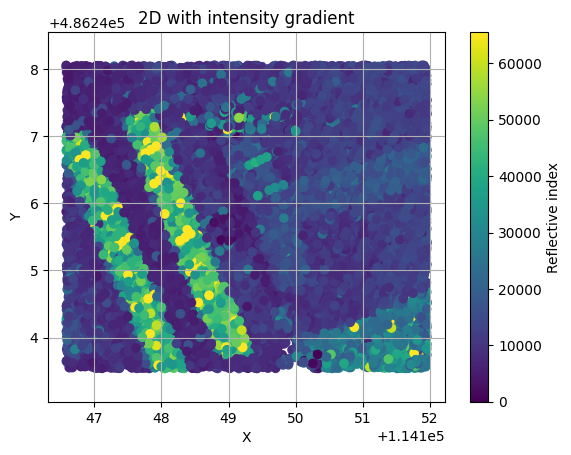

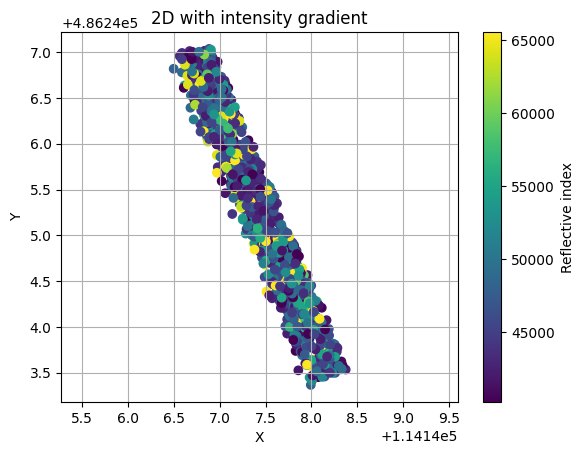

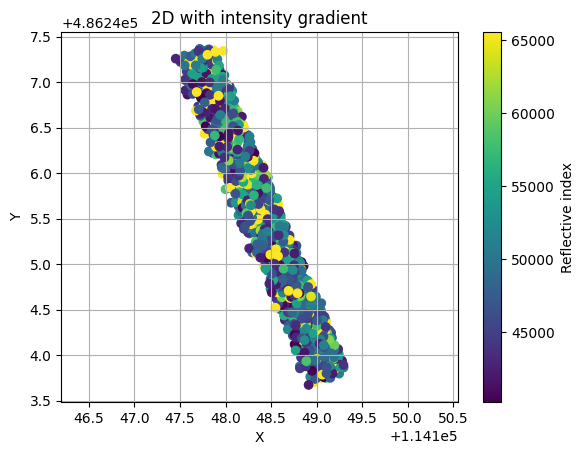

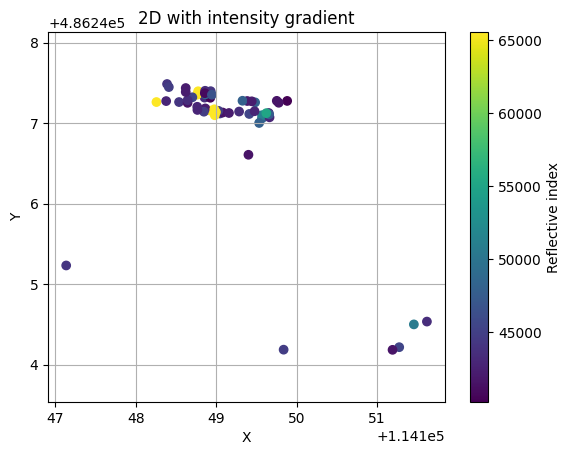

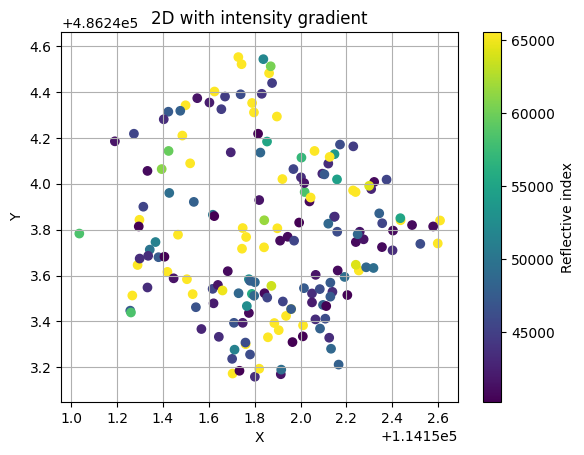

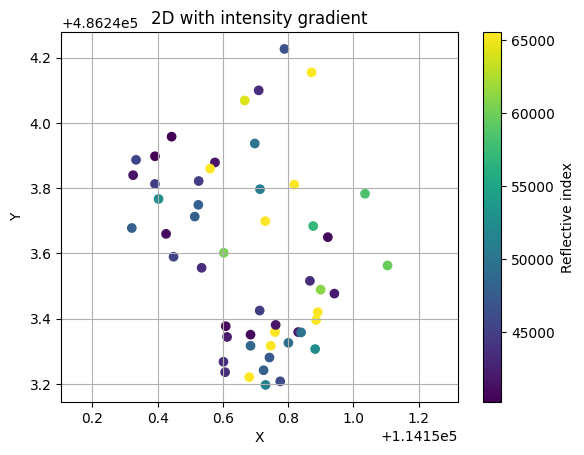

In [24]:
plot_PC_2D(merged_data[0], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_0:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [25]:
cluster_dict_1 = get_clusters(merged_data[1], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

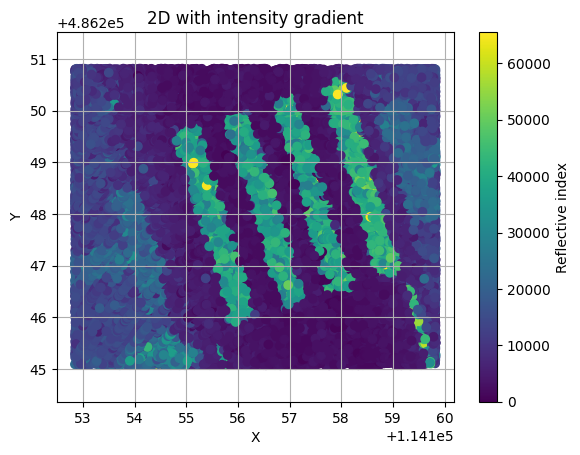

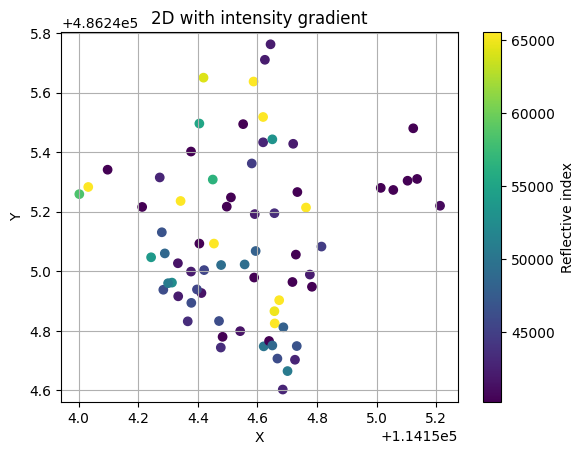

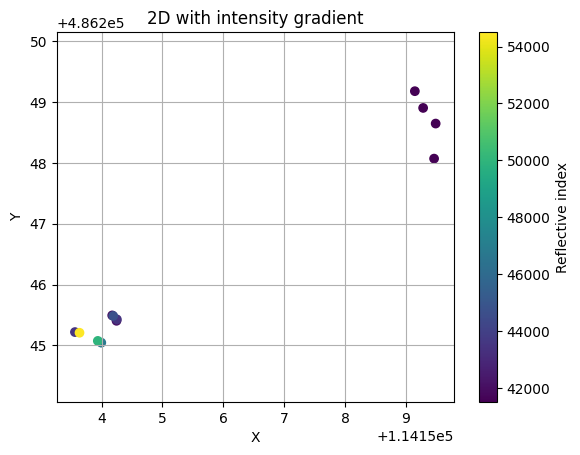

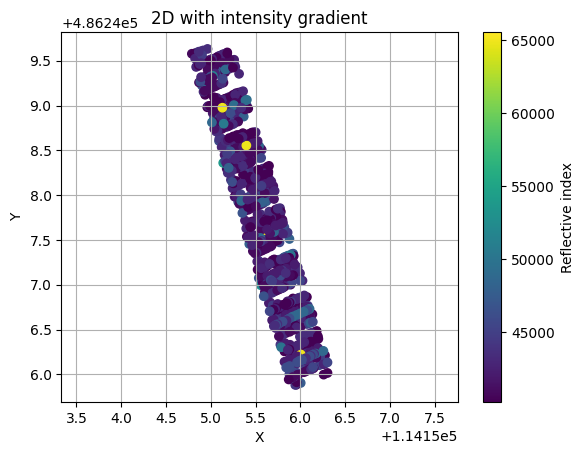

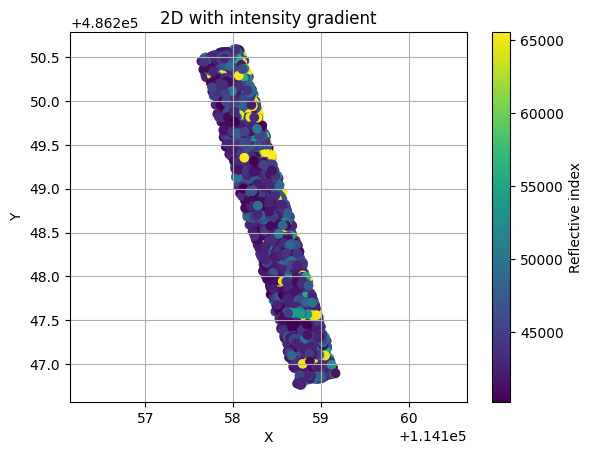

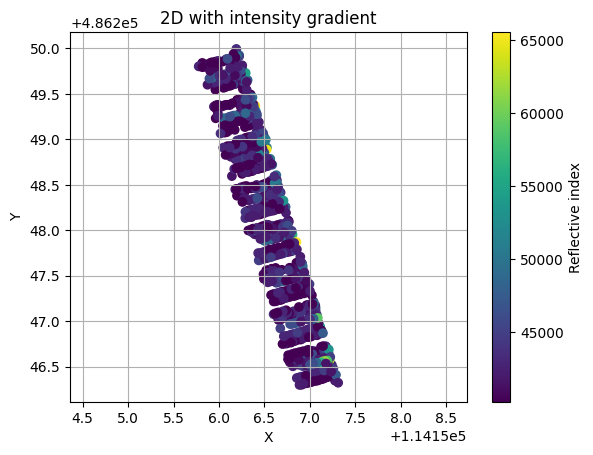

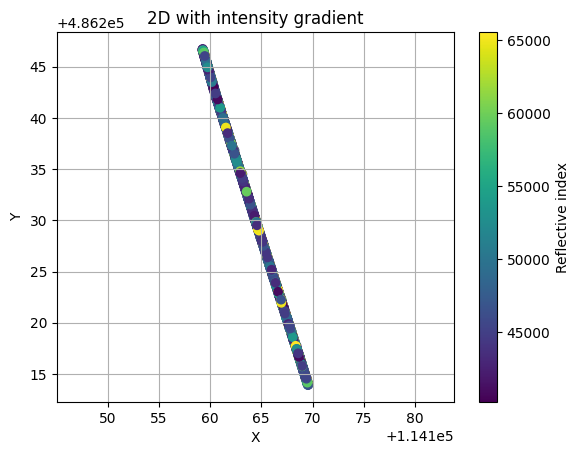

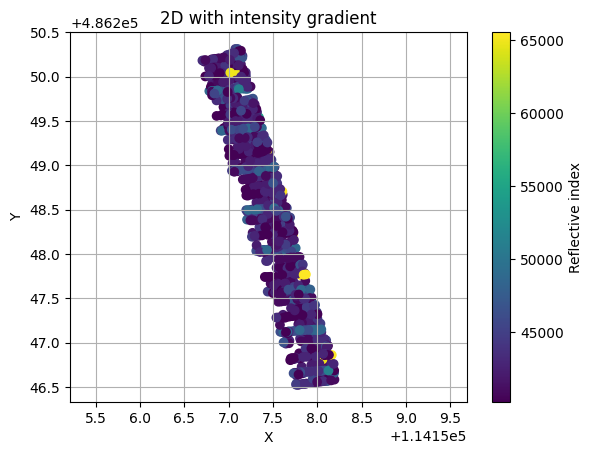

In [26]:
plot_PC_2D(merged_data[1], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_1:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [27]:
cluster_dict_2 = get_clusters(merged_data[2], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

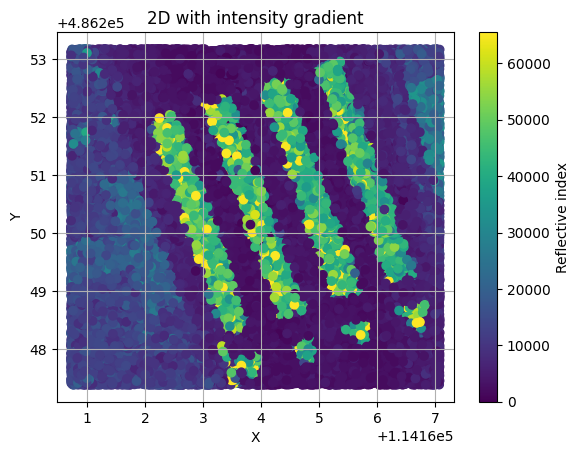

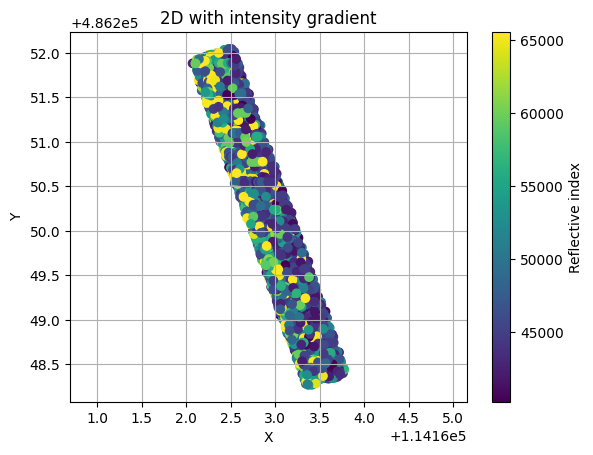

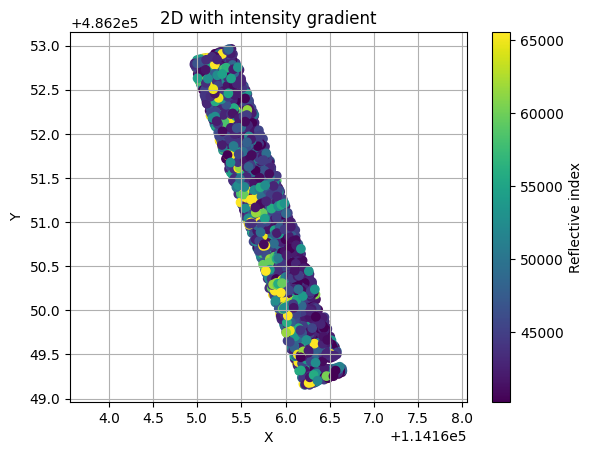

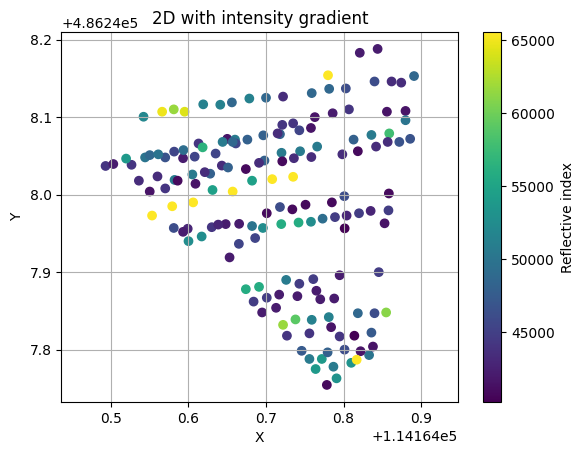

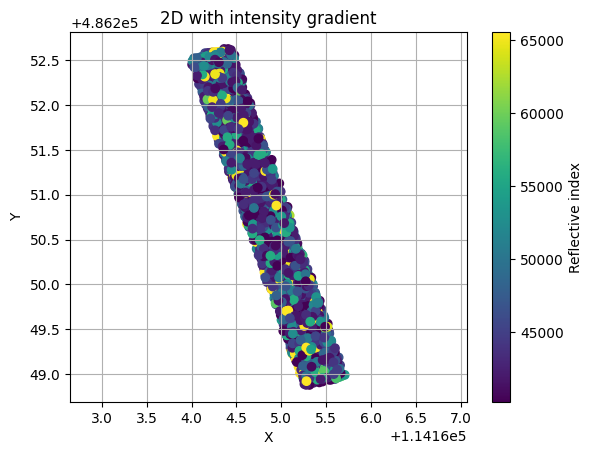

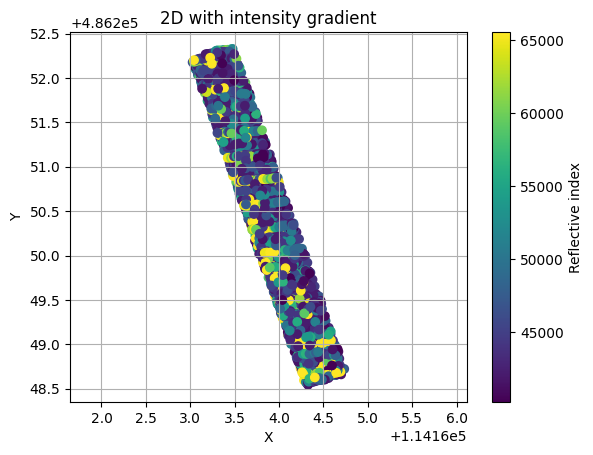

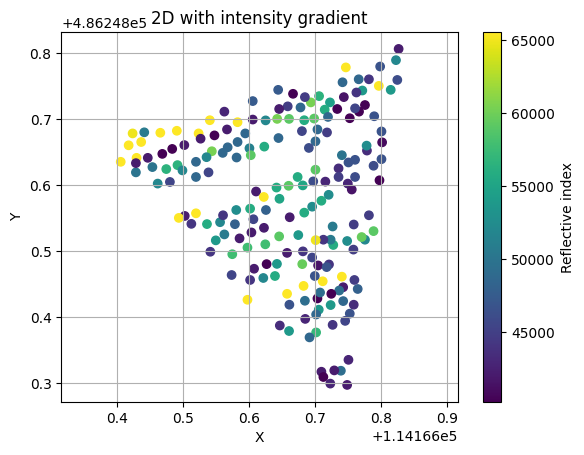

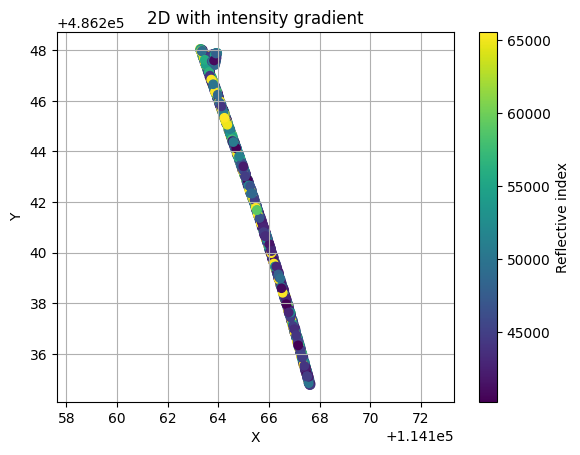

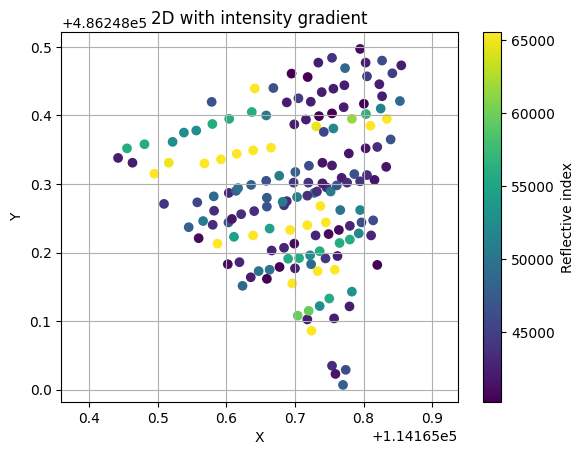

In [28]:
plot_PC_2D(merged_data[2], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_2:
    if 'clean_coords' in cluster:
        plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [29]:
cluster_dict_3 = get_clusters(merged_data[3], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

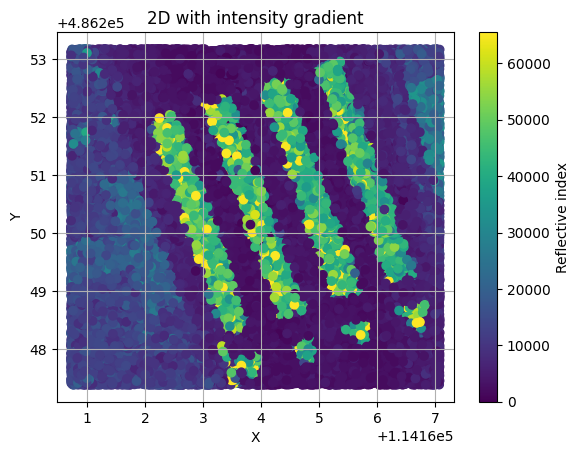

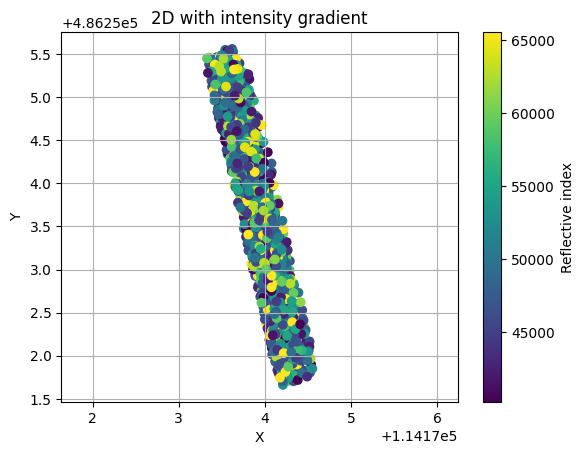

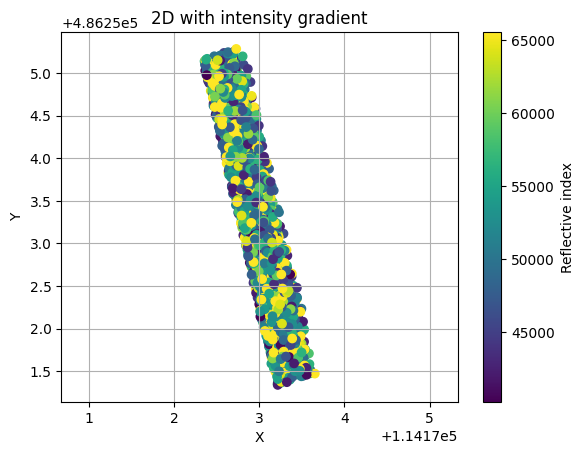

In [30]:
plot_PC_2D(merged_data[2], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_3:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [31]:
cluster_dict_4 = get_clusters(merged_data[4], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

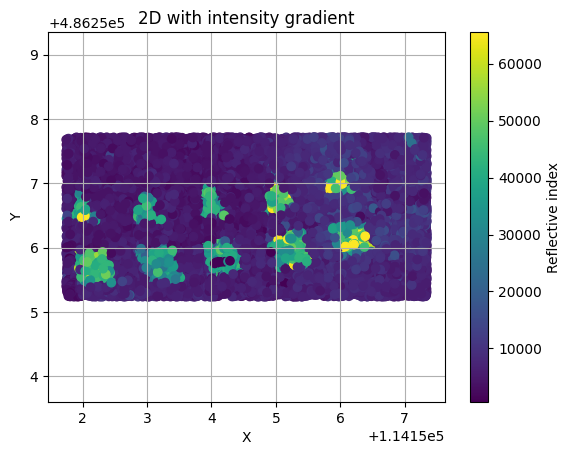

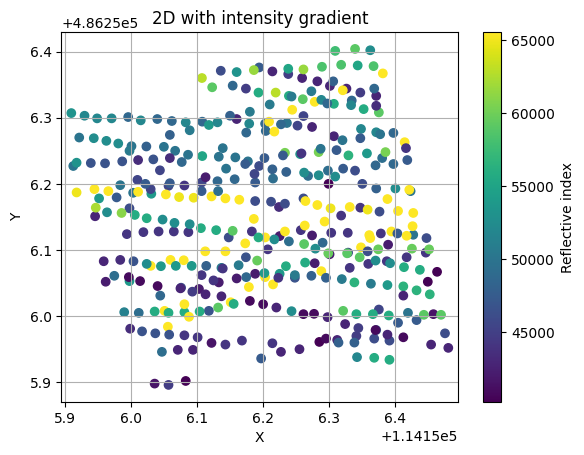

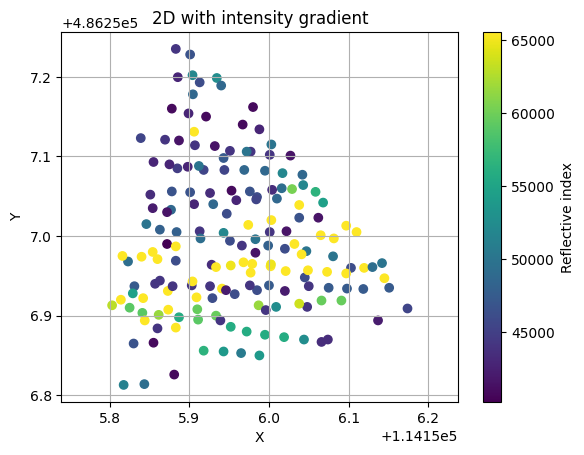

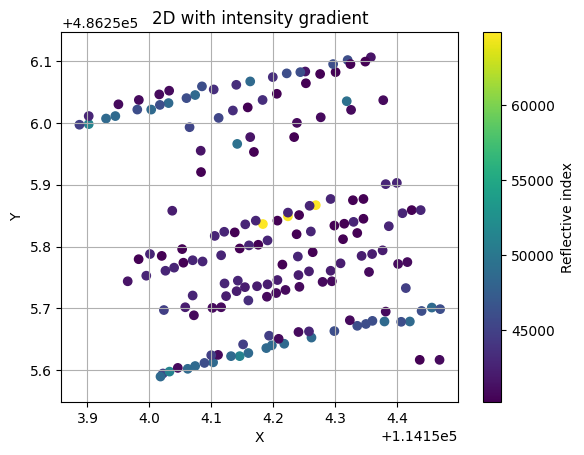

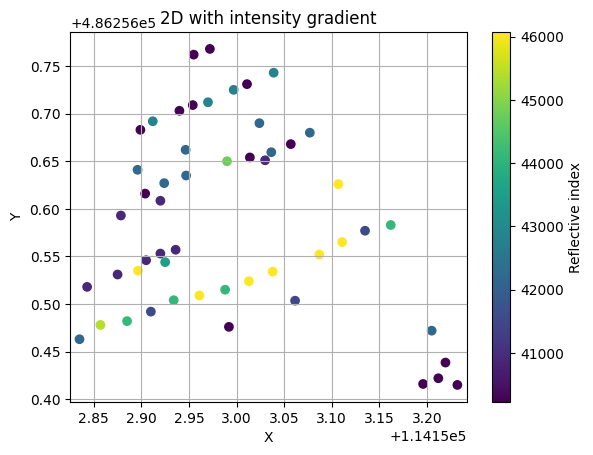

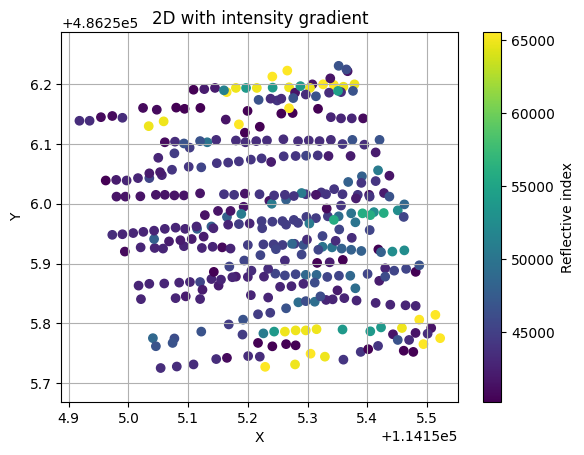

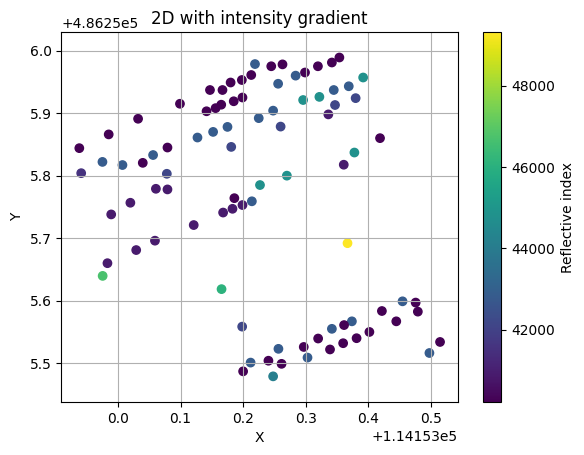

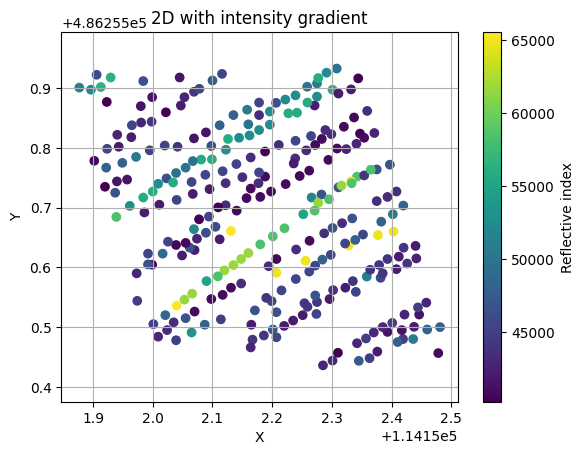

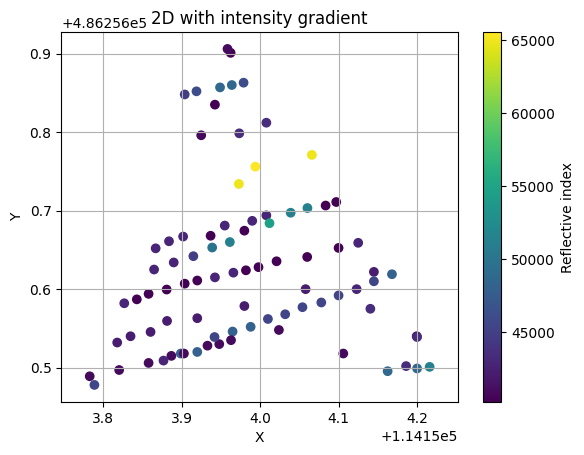

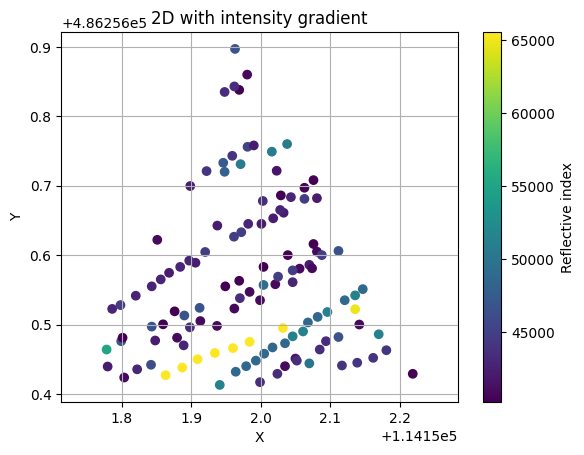

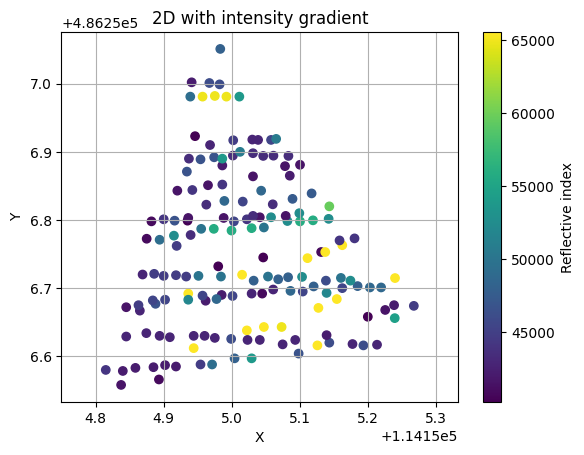

In [32]:
plot_PC_2D(merged_data[4], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_4:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [33]:
cluster_dict_5 = get_clusters(merged_data[5], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

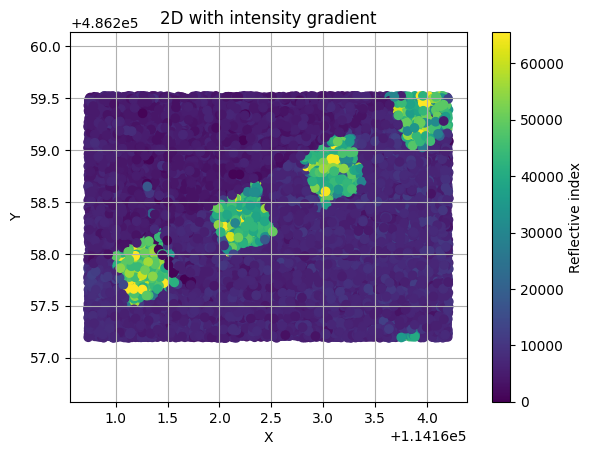

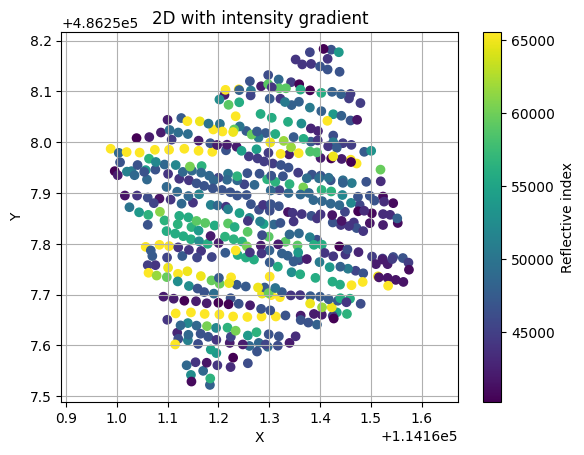

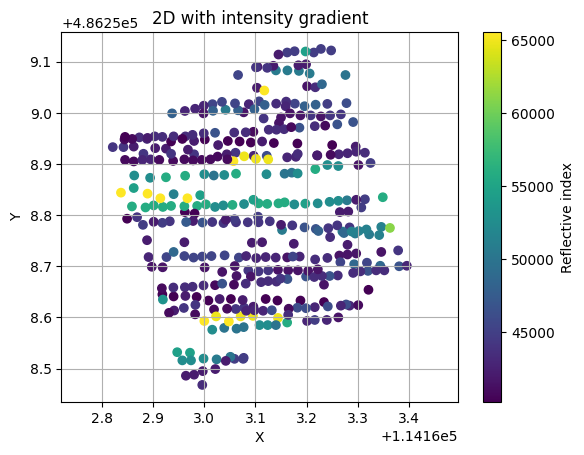

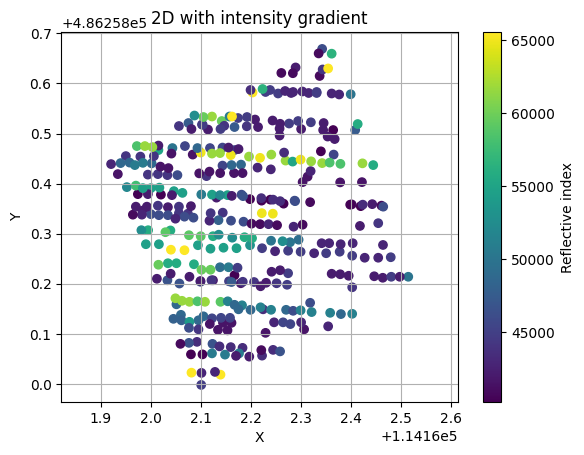

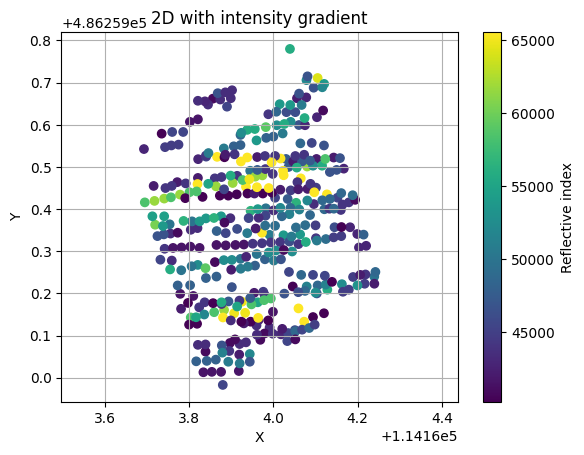

In [34]:
plot_PC_2D(merged_data[5], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_5:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [35]:
cluster_dict_6 = get_clusters(merged_data[6], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

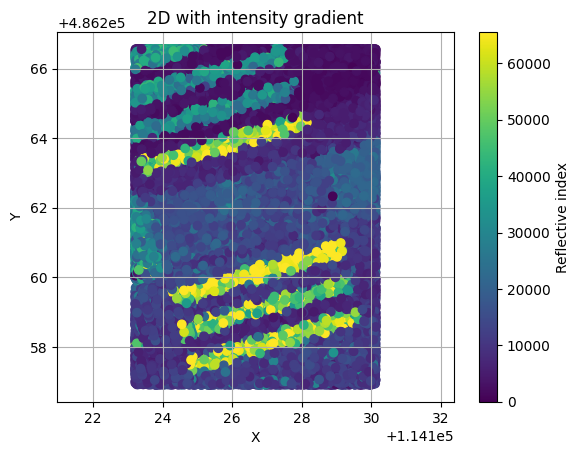

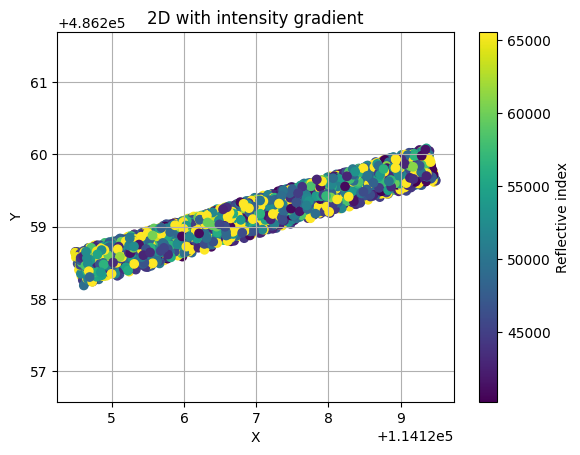

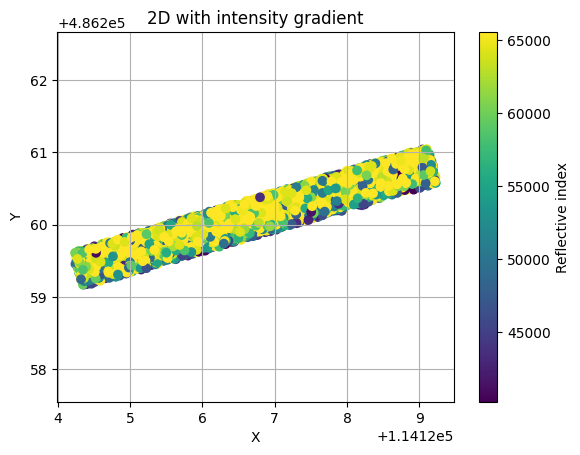

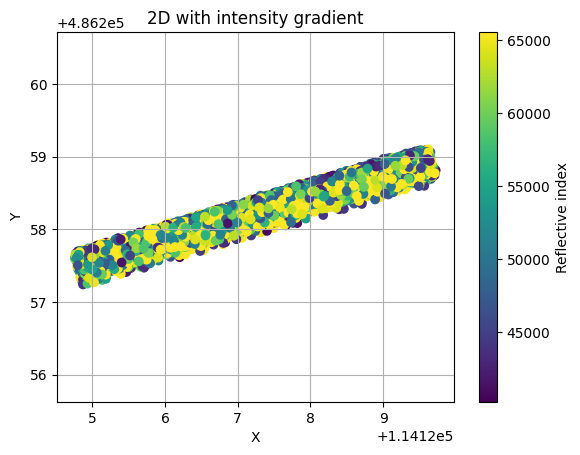

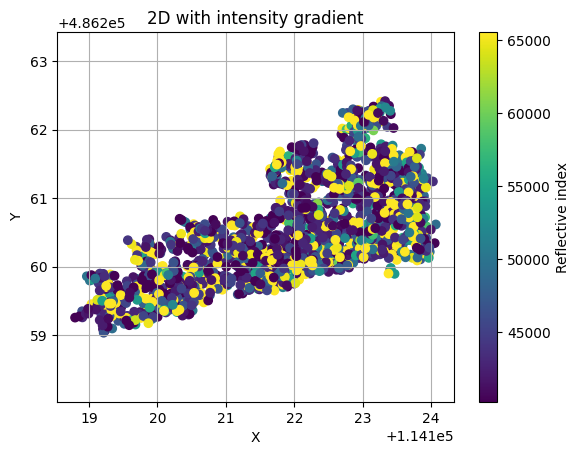

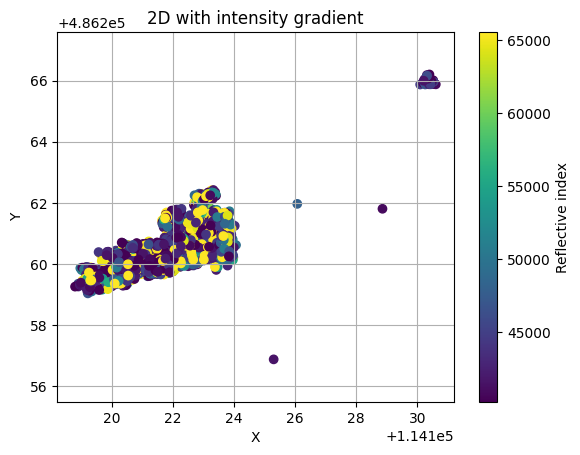

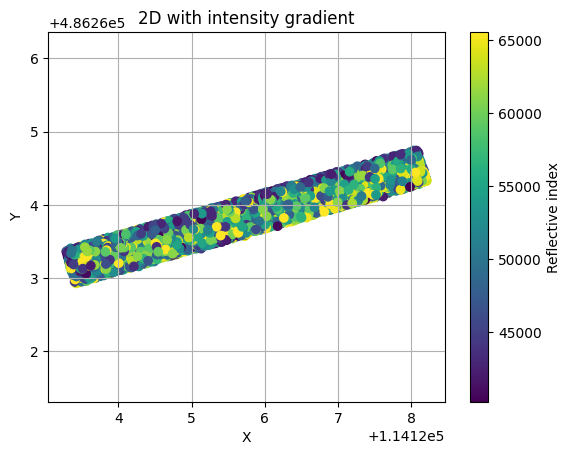

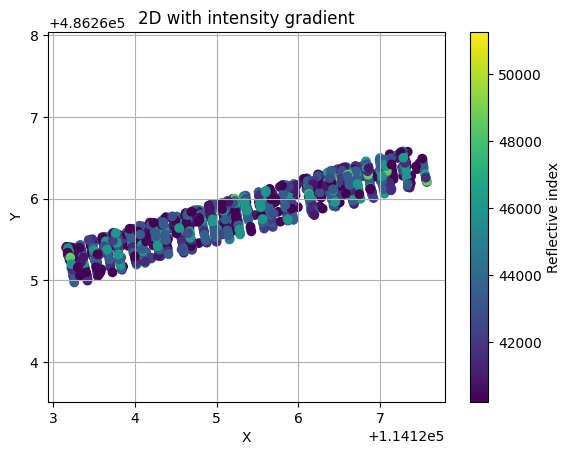

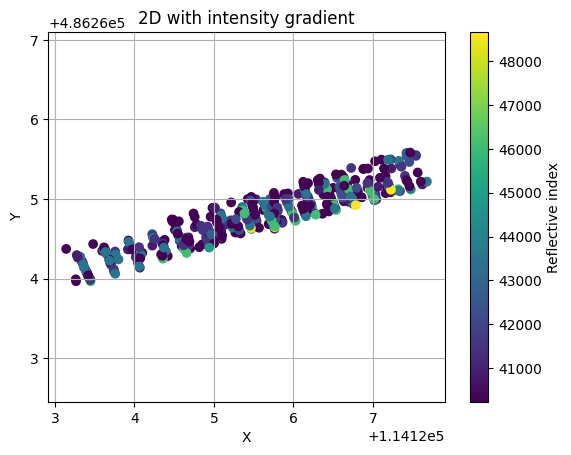

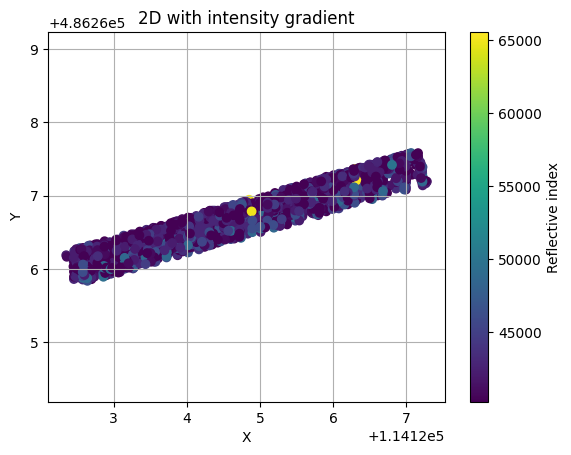

In [36]:
plot_PC_2D(merged_data[6], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_6:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [37]:
cluster_dict_7 = get_clusters(merged_data[7], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

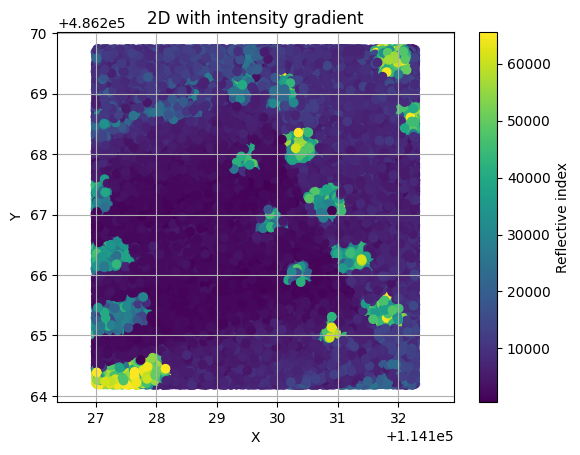

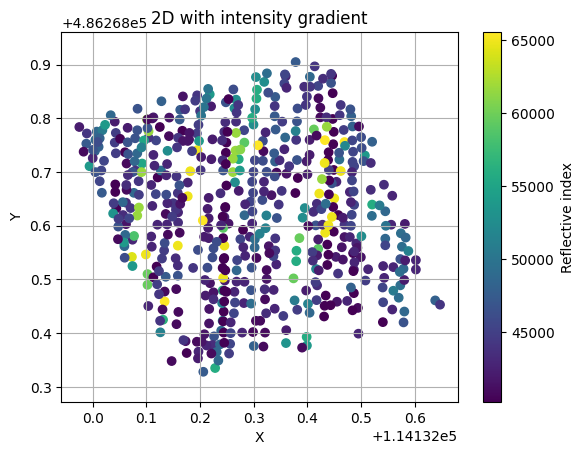

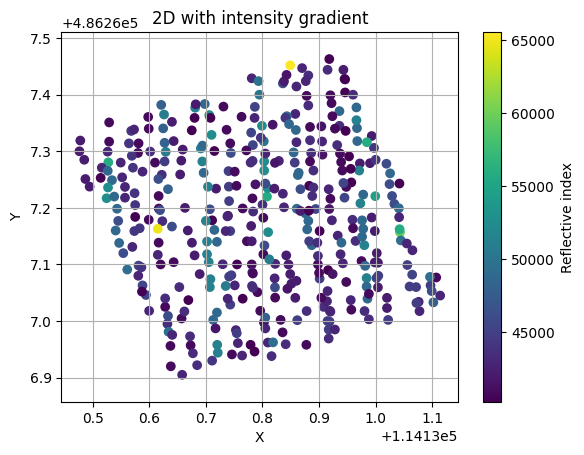

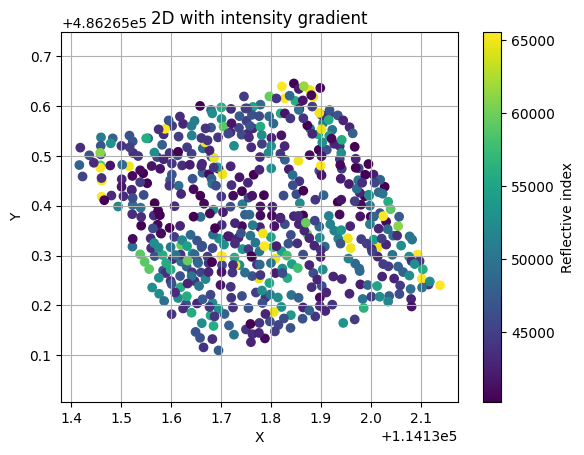

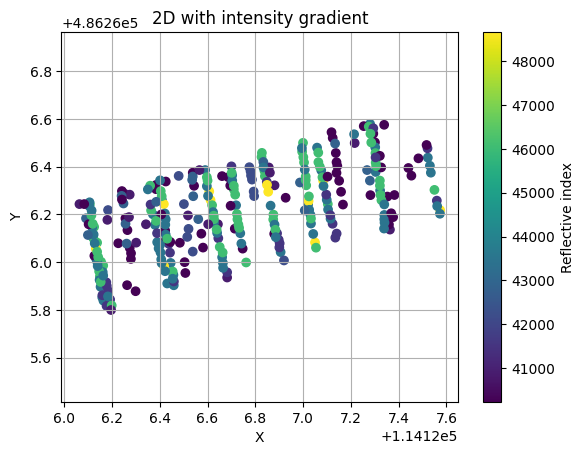

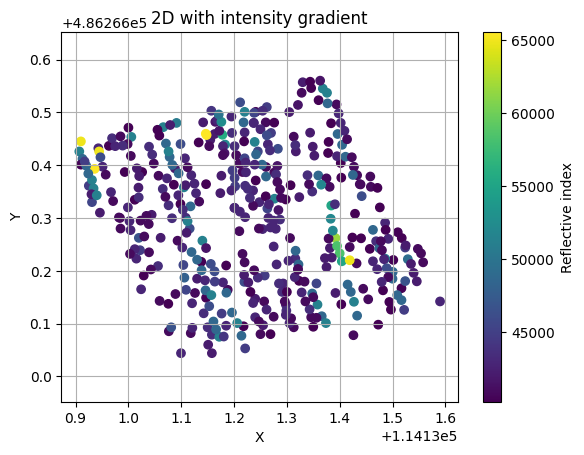

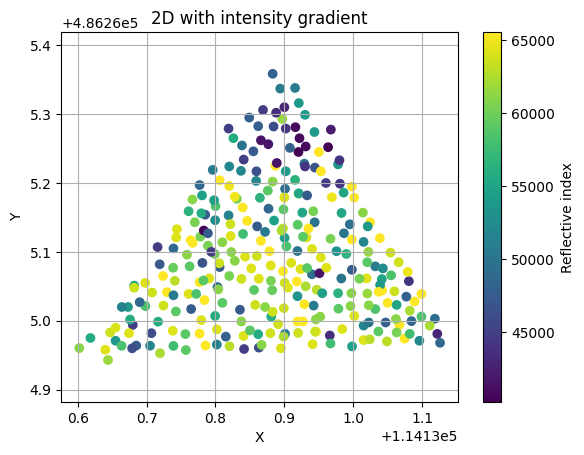

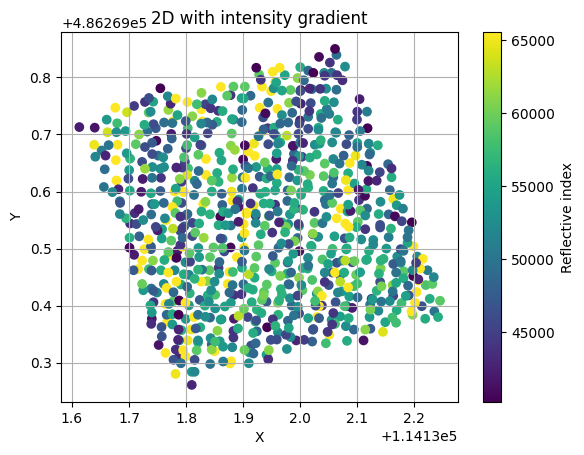

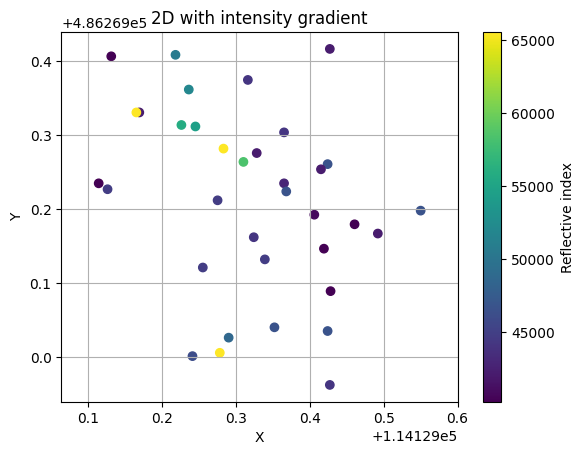

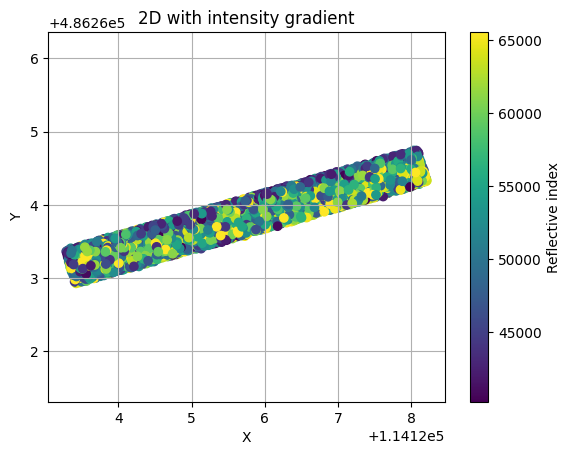

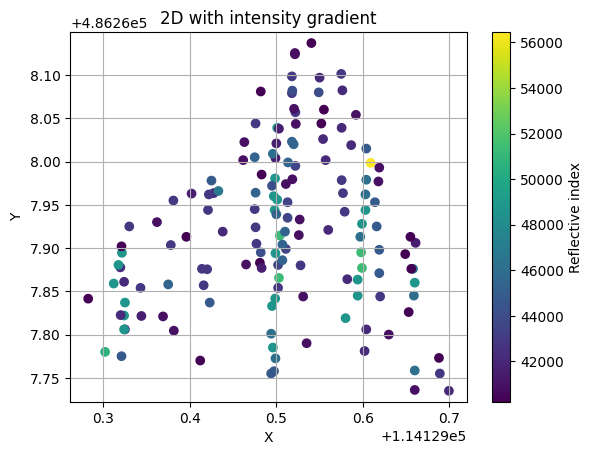

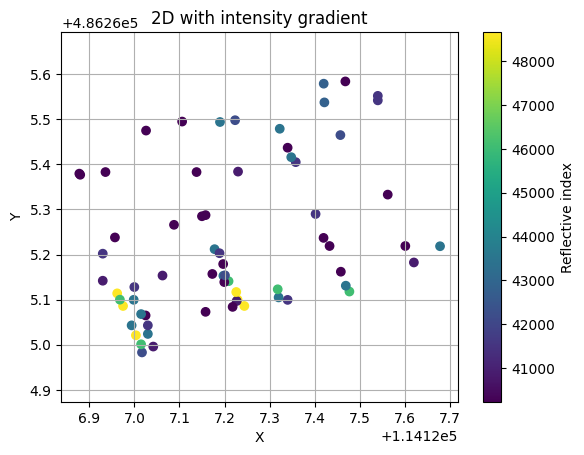

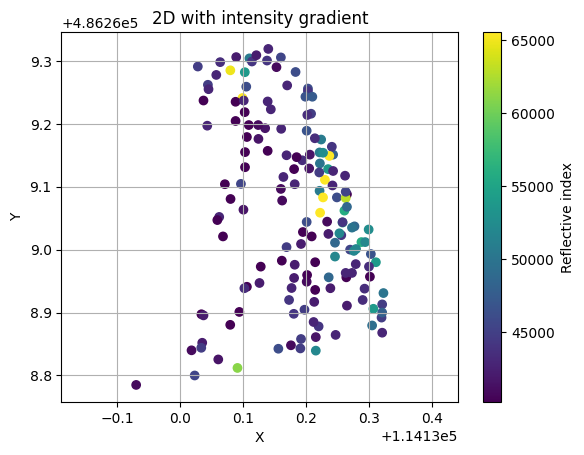

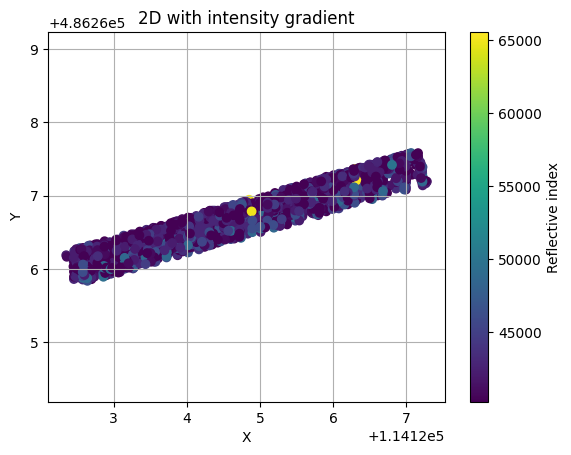

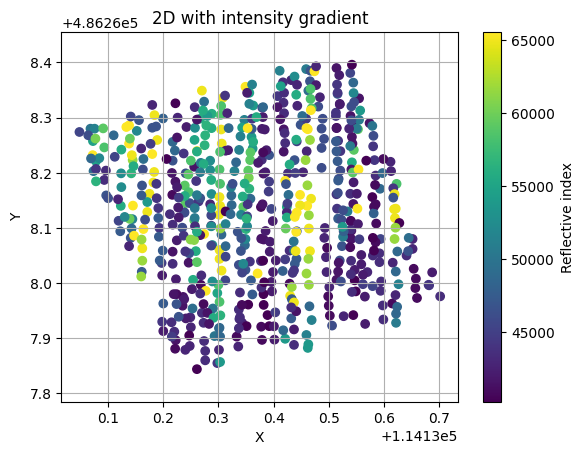

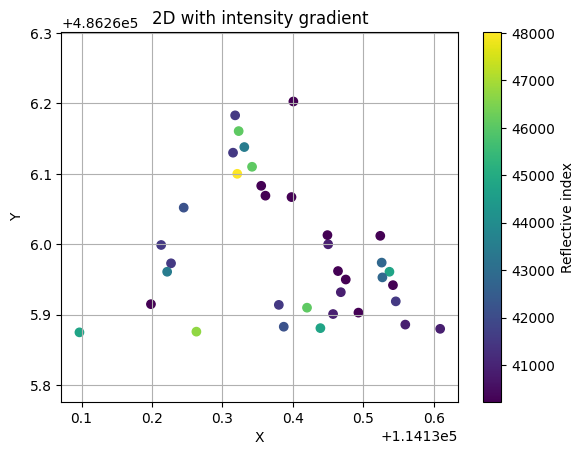

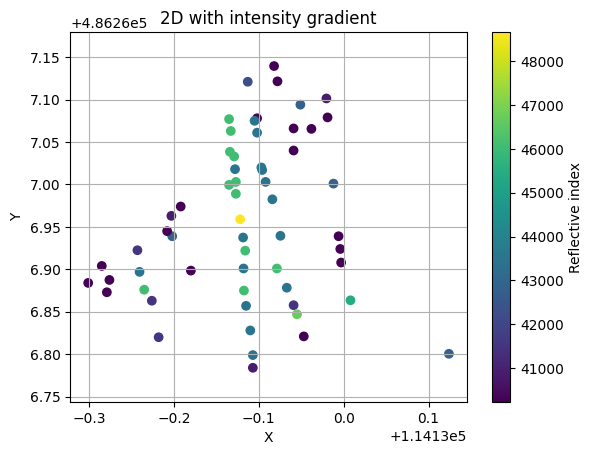

In [38]:
plot_PC_2D(merged_data[7], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_7:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [39]:
cluster_dict_8 = get_clusters(merged_data[8], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

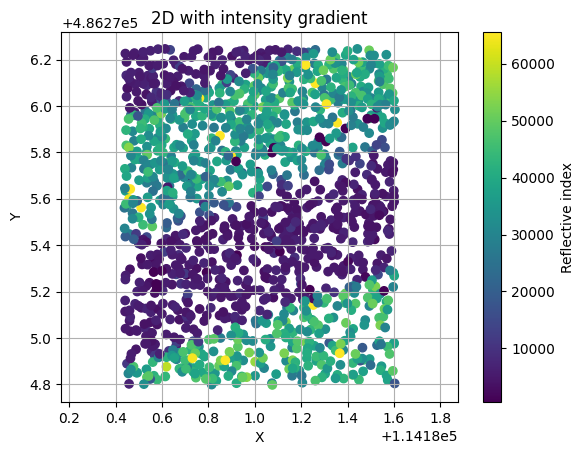

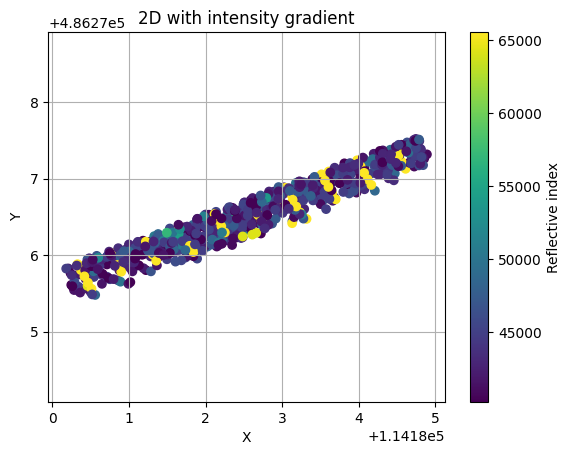

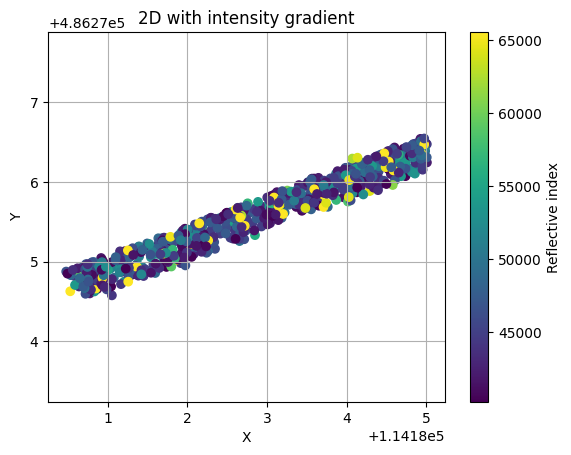

In [40]:
plot_PC_2D(merged_data[8], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_8:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [41]:
cluster_dict_9 = get_clusters(merged_data[9], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

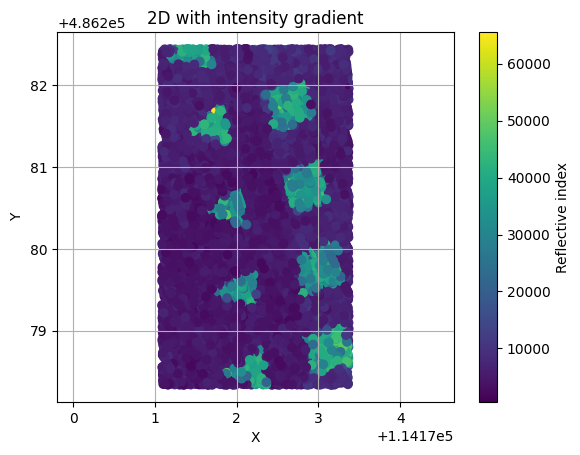

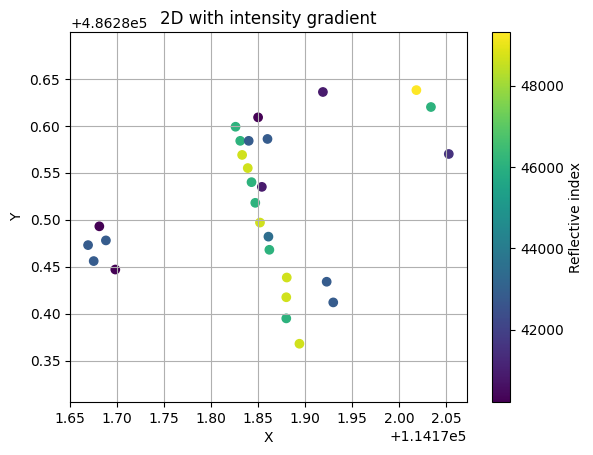

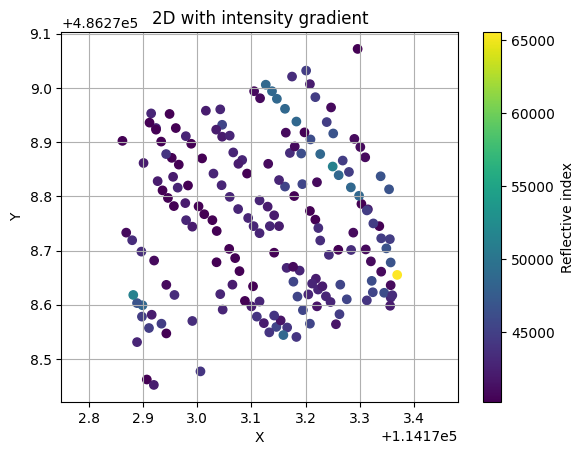

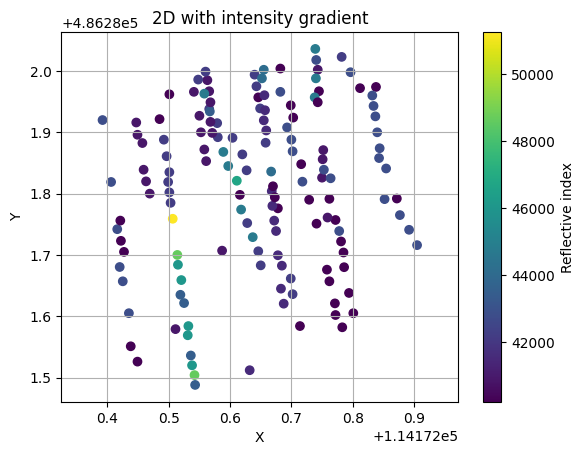

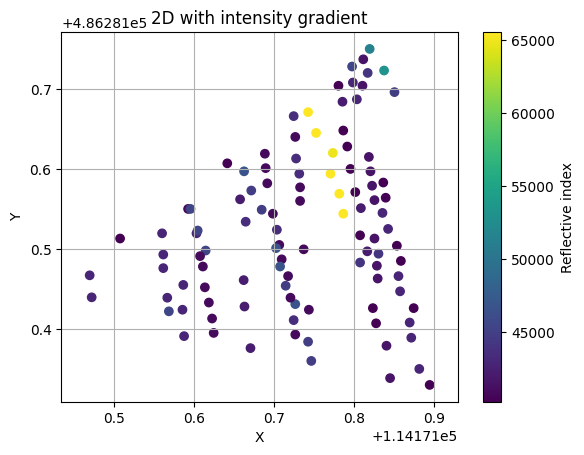

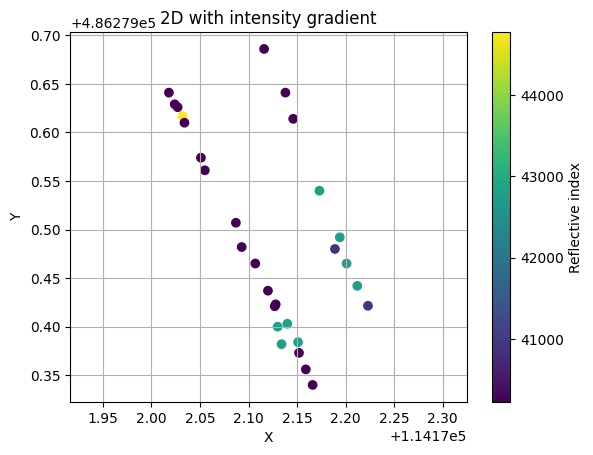

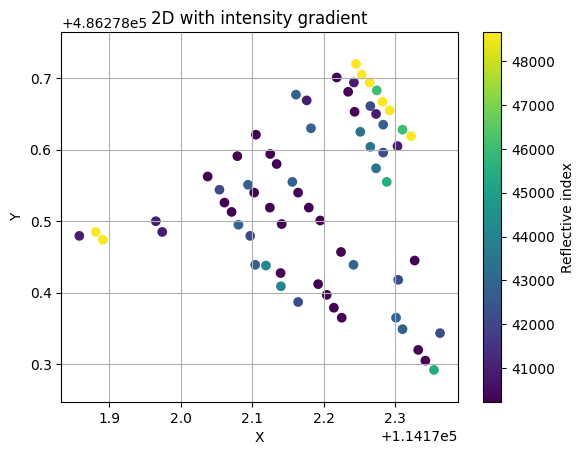

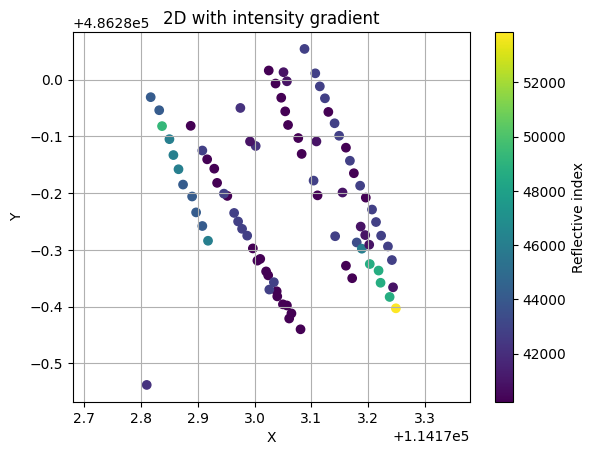

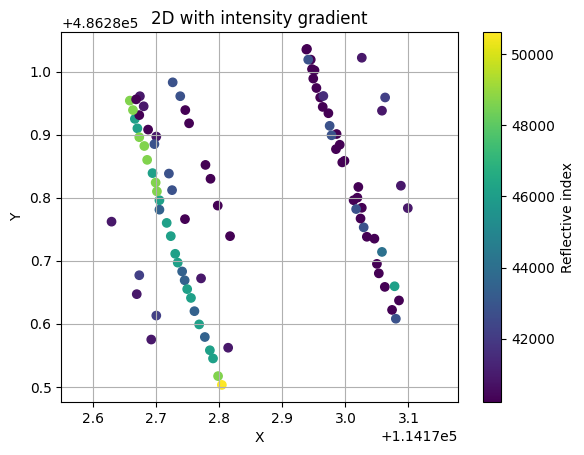

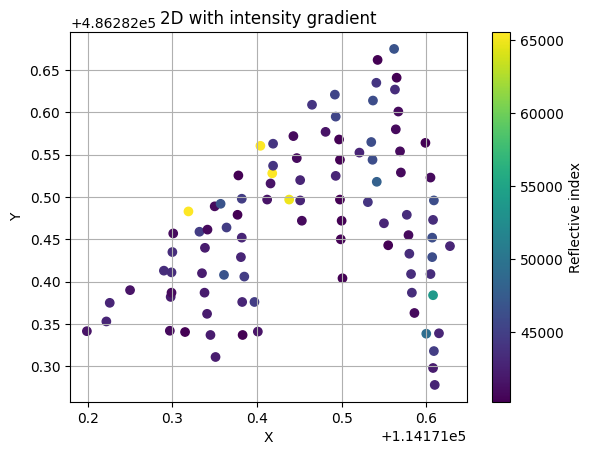

In [42]:
plot_PC_2D(merged_data[9], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_9:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')

In [43]:
cluster_dict_10 = get_clusters(merged_data[10], PCs, 'PC_coords_std_ds', 'PC_intensity_std_ds')

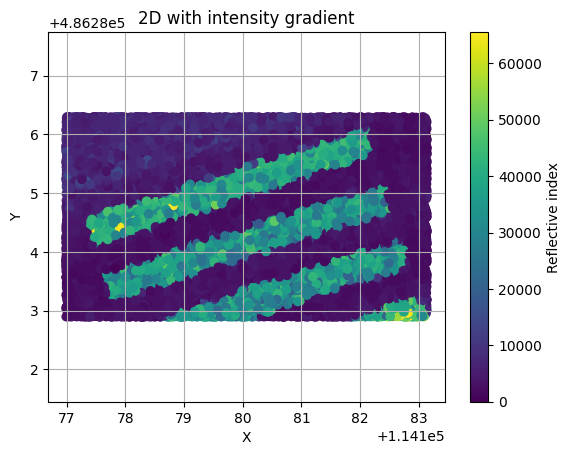

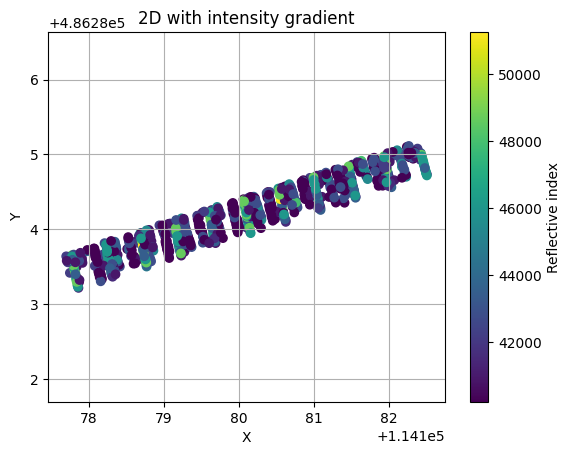

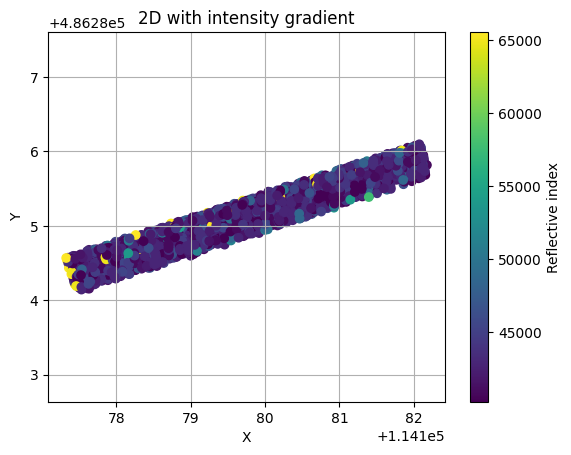

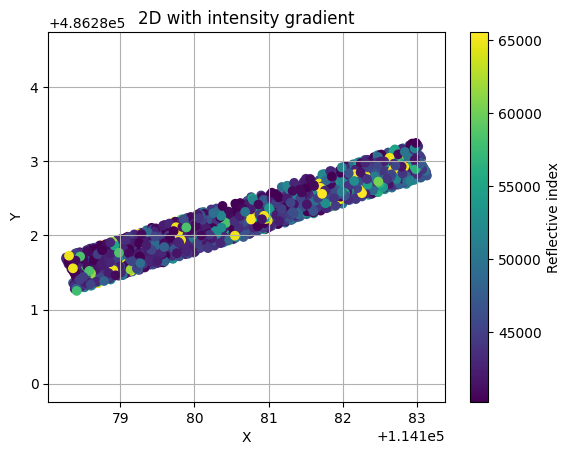

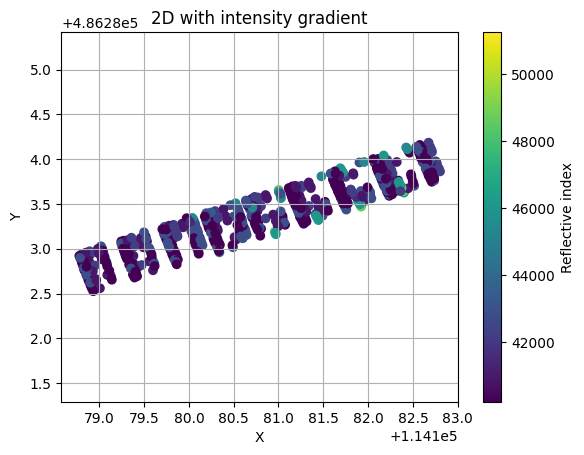

In [44]:
plot_PC_2D(merged_data[10], 'PC_coords_std_ds', 'PC_intensity_std_ds')
for cluster in cluster_dict_10:
    plot_PC_2D(cluster, 'clean_coords', 'clean_intensity')